# Dataset download and imports

It has been decided to download the complete repository as it contains fucnions and visualizations that can be useful in the discovery and performance measurement process and it already includes all the images.

In [1]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 3 (delta 0), pack-reused 758
Receiving objects: 100% (762/762), 105.85 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (444/444), done.


In [2]:
!pip3 install -r fashion-mnist/requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import sys, os
sys.path.append("fashion-mnist")
from utils import mnist_reader

In [4]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import numpy as np
import random

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Exploratory analysis of the dataset

The data is loaded as recommended in the repository, being divided into a subset of train and 60k images and 10k images for test.

The test data will be used only during the final evaluations, during training a way to validate the training performance with training subsets will be sought.

In [6]:
X_train, y_train = mnist_reader.load_mnist("fashion-mnist/data/fashion", kind="train")
X_test, y_test = mnist_reader.load_mnist("fashion-mnist/data/fashion", kind="t10k")

Checking that all data have been loaded correctly

In [7]:
len(X_train)

60000

In [8]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

plot example of every original class 

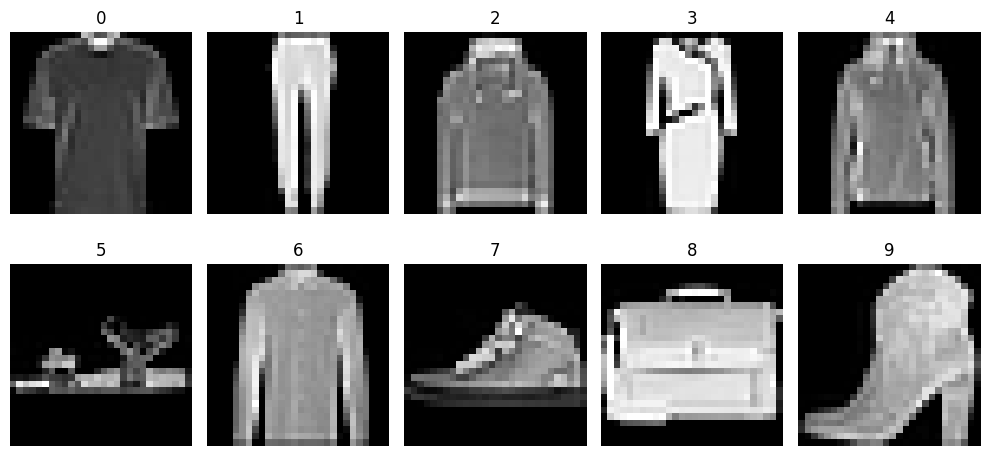

In [9]:
examples_per_class = {}
train_images_sample = X_train.reshape((-1, 28, 28))

for image, label in zip(train_images_sample, y_train):
        examples_per_class[label] = image
        
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(examples_per_class[i], cmap="gray")
    plt.title(f"{i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In the repository a UMAP representation is shown in which a strong overlap between classes can be seen in the lower left part. I will test with T-sne to see if a tighter grouping can be performed to study the final shape of the grouped dataset.

![image](./fashion-mnist/doc/img/umap_example_fashion_mnist1.png)

A new representation of the data is made using t-SNE, in order to visualize the data in a two-dimensional plane.

In [10]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_train[:5000])

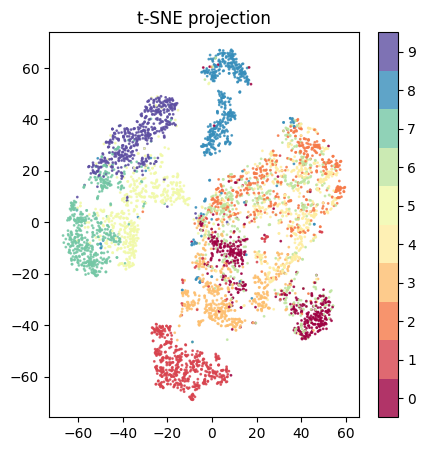

In [11]:
# Plotting the result
plt.figure(figsize=(5, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=1, c=y_train[:5000], cmap="Spectral", alpha=0.8)
plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))
plt.title("t-SNE projection")
plt.show()


There are significant differences between the different classes with some overlaps between them that will have to be taken into account.

### Now it will be shown a visualization of how the grouped classes would look like using the same method.


## Classes index

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

# Target grouped

* **Upper part**: T-shirt/top + Pullover + Coat + Shirt 
    * [0, 2, 4, 6] -> **red**
* **Bottom part**: Trouser
    * [1] -> **green**
* **One piece**: Dress
    * [3] -> **blue**
* **Footwear**: Sandal + Sneaker + Ankle boot 
    * [5, 7, 9] -> **yellow**
* **Bags**: Bag
    * [8] -> **black**
    


In [12]:
color_map = {
    0: "red",
    1: "green",
    2: "red",
    3: "blue",
    4: "red",
    5: "yellow",
    6: "red",
    7: "yellow",
    8: "black",
    9: "yellow",
}  # Groups 3 and 4: green
group_colors = [color_map[label] for label in y_train]

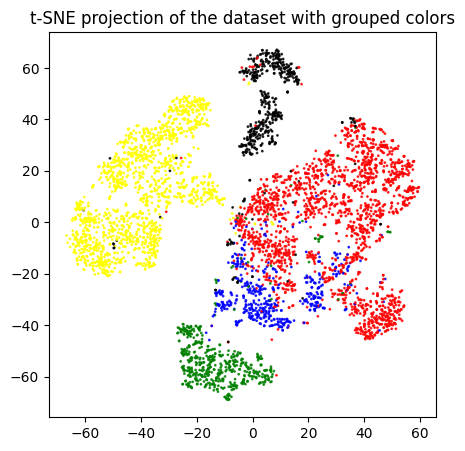

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=1, c=group_colors[:5000], alpha=0.8)
plt.title("t-SNE projection of the dataset with grouped colors")

plt.show()

### preliminary considerations based on exploratory research
Special consideration should be given to the dresses and top garments as these are the features that coincide the most in the space generated by TSNE.

to train the model I will treat the data as if the previous classes were not known, there could already be a data leakage in the training process.

It will be obviated that the previous data are known because a model adding a layer hardcoding the output to another or in case of needing a model as such, you could add a layer, make a pass on a pre-trained model and this should give results almost as good as the chosen model.

# generation of the grouped dataset

Segregate your MNIST data into these groups.

In [14]:
label_group_map = {
    0: "UpperPart",
    2: "UpperPart",
    4: "UpperPart",
    6: "UpperPart",  
    1: "BottomPart",  
    3: "OnePiece",  
    5: "Footwear",
    7: "Footwear",
    9: "Footwear",  
    8: "Bags", 
}

Map labels to camel case class names and roup the data by class name

In [15]:
features = X_train
labels = y_train

class_names = np.array([label_group_map[label] for label in labels])

data_by_class_name = {}
for feature, class_name in zip(features, class_names):
    if class_name not in data_by_class_name:
        data_by_class_name[class_name] = []
    data_by_class_name[class_name].append(feature)

Number of instances in the smallest class

In [16]:
min_class_size = min(len(v) for v in data_by_class_name.values())
min_class_size

6000

Map labels to new class names and  Group data by new class names

In [17]:
mapped_labels = np.array([label_group_map[label] for label in y_train])

data_by_class_name = {}
for feature, label in zip(features, mapped_labels):
    if label not in data_by_class_name:
        data_by_class_name[label] = []
    data_by_class_name[label].append(feature)

grouped label generation for the training process

In [18]:
unique_labels = list(set(mapped_labels))
label_to_int = {
    "UpperPart": 0,
    "BottomPart": 1,
    "OnePiece": 2,
    "Footwear": 3,
    "Bags": 4,
}
label_to_int

{'UpperPart': 0, 'BottomPart': 1, 'OnePiece': 2, 'Footwear': 3, 'Bags': 4}

the size of the smallest class

In [19]:
min_class_size = min(len(v) for v in data_by_class_name.values())
min_class_size

6000

To control the unbalance derived from the synthesized clustering of the dataset, we will create 5 balanced datasets, for the probable training of 5 models that address this issue.

In [20]:
num_datasets = 5  # Number of balanced datasets to create

In [21]:
balanced_datasets = []

for _ in range(num_datasets):
    balanced_dataset_features = []
    balanced_dataset_labels = []

    for label, data in data_by_class_name.items():
        sampled_data = random.sample(data, min_class_size)
        balanced_dataset_features.extend(sampled_data)
        balanced_dataset_labels.extend([label] * min_class_size)

    balanced_datasets.append((balanced_dataset_features, balanced_dataset_labels))


X_train_1, Y_train_1 = balanced_datasets[0]
np.unique(Y_train_1, return_counts=True)

(array(['Bags', 'BottomPart', 'Footwear', 'OnePiece', 'UpperPart'],
       dtype='<U10'),
 array([6000, 6000, 6000, 6000, 6000]))

The result is 5 datasets half the size of the original dataset.

In [22]:
len(X_train_1)

30000

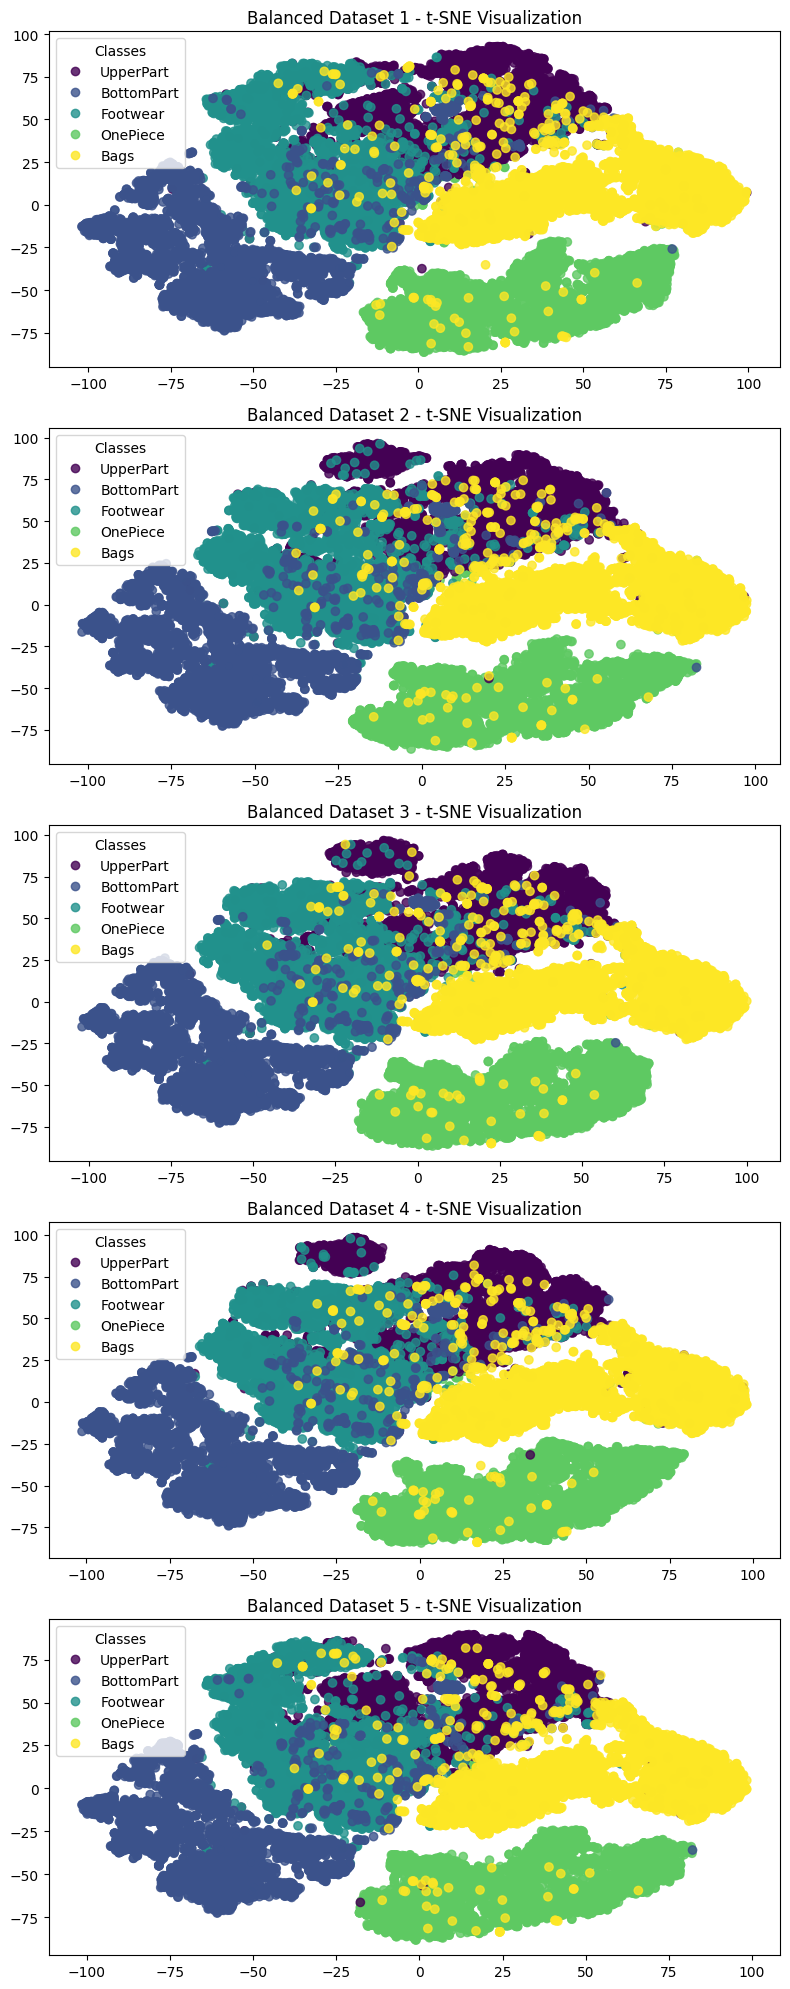

In [23]:
num_datasets = len(balanced_datasets)
fig, axes = plt.subplots(num_datasets, 1, figsize=(8, num_datasets * 4))

for i, (X_train, Y_train) in enumerate(balanced_datasets):
    
    X_train_array = np.array(X_train)

    Y_train_int = np.array([label_to_int[label] for label in Y_train])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_train_array)

    ax = axes[i] if num_datasets > 1 else axes
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_train_int, alpha=0.8)

    ax.legend(handles=scatter.legend_elements()[0], labels=unique_labels, title="Classes")
    ax.set_title(f"Balanced Dataset {i + 1} - t-SNE Visualization")

plt.tight_layout()
plt.show()


It can be seen that all datasets represent a similar sample although with some changes, several images will be repeated between different datasets but the use of multiple variations of the same dataset will help us in the robustness of the final model.

# Model building and training

A convolutional network is chosen since the exercise asks to perform a DNN model based on pytorch, without this limitation and observing the benchmark I would start by using a related model, even a clustering exercise could be a good start.

Folder for storing the checkpoints of the trained models:

In [24]:
MODELS_PATH = "models"
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)
    print(f"Created directory {MODELS_PATH}")

Created directory models


As I am using an m1 processor, I will use mps as accelerator, I add the cpu option for replicability.

In [25]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


Each example is a 28x28 grayscale image so I'll design the model based on this tensor shape:

A simple convolutional model with two convolutional layers and two linear layers is proposed, looking for a model that is below half a million parameters and that is trainable in the limited space of time.

In [26]:
class GroupedFashionClassifier(nn.Module):
    def __init__(self):
        super(GroupedFashionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, len(unique_labels))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



For the criterion **CrossEntropyLoss** is ideal for convolutional classifiers as it accurately measures model performance on probabilistic outputs, complementing softmax activation.

**ADAM optimizer**, which dynamically adjusts learning rates, it ensures faster, more efficient convergence

In [27]:
model = GroupedFashionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
model

GroupedFashionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

Number of trainable parameters

In [29]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params

420997

In [30]:
X_train, Y_train = balanced_datasets[0]

Split the dataset into training and validation sets

In [31]:

X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=10
)

Visual check that the original distribution of validation classes is balanced.

In [32]:
np.unique(Y_val_split, return_counts=True)

(array(['Bags', 'BottomPart', 'Footwear', 'OnePiece', 'UpperPart'],
       dtype='<U10'),
 array([1224, 1130, 1211, 1207, 1228]))

Convert to PyTorch tensors and move to the appropriate device

In [33]:
def process_data(X, Y):
    X_array = np.array(X).reshape(-1, 1, 28, 28)
    X_tensor = torch.tensor(X_array, dtype=torch.float32).to(device)
    Y_tensor = torch.tensor([label_to_int[label] for label in Y], dtype=torch.long).to(device)
    return X_tensor, Y_tensor

Choosen metrics for this problem are:
* **accuracy**  indication of the overall effectiveness of the classifier in correctly predicting all classes
* **precision**  it highlights the model's ability to correctly identify positive instances among all instances labeled as positive, usefull to detect false positives.
* **recall** it measures the model's capability to find all actual positive instances, essential in cases where missing a positive is costly
* **f1 score**  balances precision and recall, providing a more comprehensive view of the model's performance.
* **Confusion matrix**: provides insights into which classes are being confused by the model, helping to fine-tune and improve it

In [34]:
def print_metrics(labels_np, predicted_np):
    precision = precision_score(labels_np, predicted_np, average="weighted")
    recall = recall_score(labels_np, predicted_np, average="weighted")
    f1 = f1_score(labels_np, predicted_np, average="weighted")

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    cm = confusion_matrix(labels_np, predicted_np, labels=list(label_to_int.values()))
    print(f"Confusion Matrix:\n{cm}")

Prepare data and turn it into pytorch tensors

In [35]:
X_train_tensor, Y_train_tensor = process_data(X_train_split, Y_train_split)
X_val_tensor, Y_val_tensor = process_data(X_val_split, Y_val_split)

In [36]:
# DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=len(X_val_split))

## Training loop

hardcoded epoch to 10 (future work: add early stopping)

In [37]:
model_save_path_template = "model_dataset_{}.pth"

In [38]:
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(val_loader))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_np = predicted.cpu().numpy()
        accuracy = accuracy_score(labels.cpu().numpy(), predicted_np)
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy}%"
        )
# Save the trained model
model_save_path = model_save_path_template.format(1)
torch.save(model.state_dict(), os.path.join(MODELS_PATH, model_save_path))

Epoch [1/10], Loss: 0.1646, Validation Accuracy: 0.9641666666666666%
Epoch [2/10], Loss: 0.2355, Validation Accuracy: 0.966%
Epoch [3/10], Loss: 0.1663, Validation Accuracy: 0.9721666666666666%
Epoch [4/10], Loss: 0.0967, Validation Accuracy: 0.9685%
Epoch [5/10], Loss: 0.0140, Validation Accuracy: 0.9733333333333334%
Epoch [6/10], Loss: 0.0172, Validation Accuracy: 0.9705%
Epoch [7/10], Loss: 0.0048, Validation Accuracy: 0.9756666666666667%
Epoch [8/10], Loss: 0.0251, Validation Accuracy: 0.9698333333333333%
Epoch [9/10], Loss: 0.0077, Validation Accuracy: 0.968%
Epoch [10/10], Loss: 0.1261, Validation Accuracy: 0.9665%


Model performance evaluation over validation dataset

In [39]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    images, labels = next(iter(val_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    predicted_np = predicted.cpu().numpy()
    labels_np = labels.cpu().numpy()

    print_metrics(labels_np, predicted_np)

Precision: 0.9665, Recall: 0.9665, F1: 0.9665
Confusion Matrix:
[[1150    5   58    0   15]
 [   2 1115    8    0    5]
 [  89    3 1110    0    5]
 [   0    0    0 1211    0]
 [   8    0    2    1 1213]]


As some classes are encountering differences and errors, we are going to perform ensemble training a model of the same type against each of the splits of the generated dataset to try to solve this problem.

Each of the trained models will be stored to be reused in the ensemble. 

(Code is repeated using in the simple training loop 😅, quite improvable...)

In [40]:
num_epochs = 10

for dataset_index, (X_train, Y_train) in enumerate(balanced_datasets[1:], start=1):
    print(f"Training on dataset {dataset_index +1}")

    X_train, Y_train = balanced_datasets[dataset_index]

    X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
        X_train, Y_train, test_size=0.2, random_state=10
    )

    X_train_tensor, Y_train_tensor = process_data(X_train_split, Y_train_split)
    X_val_tensor, Y_val_tensor = process_data(X_val_split, Y_val_split)

    # DataLoader for training and validation sets
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=len(X_val_split))

    # Define and initialize the model
    model = GroupedFashionClassifier().to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            images, labels = next(iter(val_loader))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predicted_np = predicted.cpu().numpy()
            accuracy = accuracy_score(labels.cpu().numpy(), predicted_np)
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy}%"
            )
    # Save the trained model
    model_save_path = model_save_path_template.format(dataset_index + 1)
    torch.save(model.state_dict(), os.path.join(MODELS_PATH, model_save_path))

Training on dataset 2
Epoch [1/10], Loss: 0.1058, Validation Accuracy: 0.9595%
Epoch [2/10], Loss: 0.0033, Validation Accuracy: 0.9656666666666667%
Epoch [3/10], Loss: 0.0725, Validation Accuracy: 0.9681666666666666%
Epoch [4/10], Loss: 0.0302, Validation Accuracy: 0.9711666666666666%
Epoch [5/10], Loss: 0.0463, Validation Accuracy: 0.97%
Epoch [6/10], Loss: 0.0415, Validation Accuracy: 0.9701666666666666%
Epoch [7/10], Loss: 0.0301, Validation Accuracy: 0.975%
Epoch [8/10], Loss: 0.0046, Validation Accuracy: 0.9721666666666666%
Epoch [9/10], Loss: 0.0887, Validation Accuracy: 0.9676666666666667%
Epoch [10/10], Loss: 0.0619, Validation Accuracy: 0.9721666666666666%
Training on dataset 3
Epoch [1/10], Loss: 0.3109, Validation Accuracy: 0.9593333333333334%
Epoch [2/10], Loss: 0.0473, Validation Accuracy: 0.9585%
Epoch [3/10], Loss: 0.0190, Validation Accuracy: 0.9691666666666666%
Epoch [4/10], Loss: 0.0398, Validation Accuracy: 0.9715%
Epoch [5/10], Loss: 0.0583, Validation Accuracy: 0.9

# Predictions in the test dataset

In [41]:
test_class_names = np.array([label_group_map[label] for label in y_test])
X_test_tensor, Y_test_tensor = process_data(X_test, test_class_names)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=len(Y_test_tensor))

First, the performance of the simple approach is evaluated using a single model:

In [42]:
def load_model(model_path):
    model = GroupedFashionClassifier().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [43]:
model = load_model("models/model_dataset_1.pth")

In [44]:
with torch.no_grad():
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    predicted_np = predicted.cpu().numpy()
    labels_np = labels.cpu().numpy()

    print_metrics(labels_np, predicted_np)

Precision: 0.9701, Recall: 0.9689, F1: 0.9692
Confusion Matrix:
[[3794   11  141    3   51]
 [   1  986   12    0    1]
 [  68    4  927    0    1]
 [   0    0    0 2996    4]
 [   5    0    5    4  986]]


The ensemble is now evaluated 

In [45]:
# Map labels to camel case class names
test_class_names = np.array([label_group_map[label] for label in y_test])
X_test_tensor, Y_test_tensor = process_data(X_test, test_class_names)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=len(Y_test_tensor))

All models are loaded to make an isolated prediction of each image for each of the 5 models so that a "quorum of opinions" can be generated between the data seen by each of them:

In [46]:
models = [
    load_model(os.path.join(MODELS_PATH, model_save_path_template.format(i + 1)))
    for i in range(len(balanced_datasets))
]

In [47]:
ensemble_predictions = []

with torch.no_grad():
    images, labels = next(iter(test_loader))
    outputs = [model(images) for model in models]
    avg_output = torch.mean(torch.stack(outputs), dim=0)
    ensemble_predictions.append(avg_output.argmax(dim=1).cpu().numpy())

    predicted_np = ensemble_predictions[0]
    labels_np = labels.cpu().numpy()

    print_metrics(labels_np, predicted_np)

Precision: 0.9789, Recall: 0.9775, F1: 0.9779
Confusion Matrix:
[[3837    5  141    3   14]
 [   2  989    8    0    1]
 [  31    7  962    0    0]
 [   1    0    0 2999    0]
 [   4    1    3    4  988]]


With the ensemble of models it can be seen that the dataset extends the performance, perhaps increasing the number of synthetic datasets that are created from 5 will achieve a result with better functionalities

Using an ensemble adds processing overhead, although in this case it could be justified, since the added robustness to the model is evident, and invites to iterate on this approach to try to improve the results obtained.

# TODO list
* Use k-fold on each of the sub datasets for training and validation.
* Normalize the images to optimize model convergence.
* Study the variance between the predictions of the ensemble models for future discarding of the most similar ones in the voting.
* Clean the outlayers of the ensemble dataset to protect from model overifitting in case there is no other option.
* Try with an unbalanced dataset and perform the ensemble with it or even concentrate specialized models in one class.